Generated dataset: (900, 20)
Saved: /content/project9_output/hierarchical_dataset.csv

Architecture rollup:
    arch  units  mean_dpm_bump  mean_dpm_die  unit_fail_rate  mean_overlay_mag_um  mean_warpage_um  mean_pitch_um  mean_dpm_unit
    2.5D    192      72.359422  69444.444444        0.135417             3.111960        39.437431      64.010417  135416.666667
  FanOut    358      19.463582  23510.242086        0.061453             1.843091        40.964561      63.631285   61452.513966
FlipChip    350      30.661859  25000.000000        0.054286             2.581973        38.629212      66.400000   54285.714286
Saved rollups: /content/project9_output/dpm_rollups.csv


/tmp/ipython-input-3016901501.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pitch_roll = df.groupby(["arch", pitch_bins]).agg(


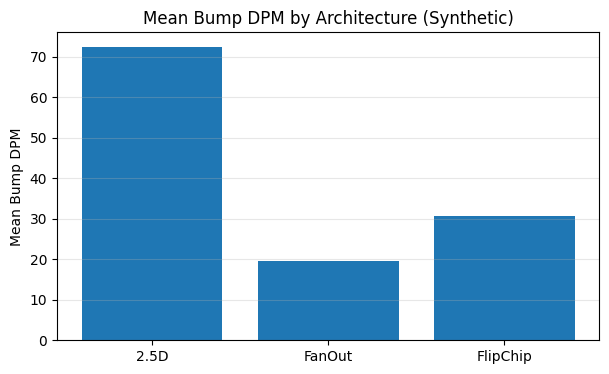


ML: Predicting dpm_bump
R2  = 0.304
MAE = 63.24 DPM
Saved ML predictions: /content/project9_output/ml_dpm_predictions.csv


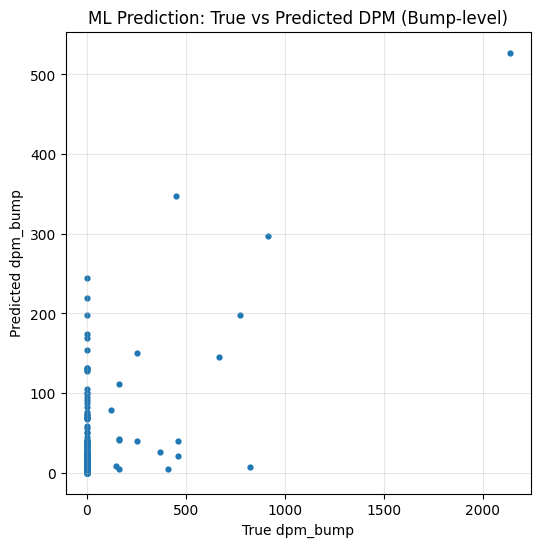


Uncertainty (MC) for predicted bump DPM at typical design point by architecture:
    arch  dpm_mean  dpm_p05  dpm_p50    dpm_p95
  FanOut  1.948937 0.101688 0.101688  10.765982
FlipChip  4.008326 0.000000 0.000000  19.306077
    2.5D 13.556597 0.345423 2.086712 131.191321
Saved: /content/project9_output/dpm_uncertainty_by_arch.csv


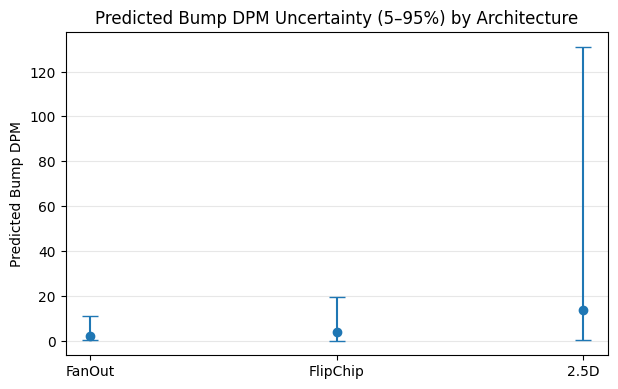


Outputs saved in: /content/project9_output
 - hierarchical_dataset.csv
 - dpm_rollups.csv
 - ml_dpm_predictions.csv
 - dpm_uncertainty_by_arch.csv

In Colab: left sidebar → Files → project9_output → download artifacts


In [1]:
# ============================================================
# Project 8 — Hierarchical Overlay → DPM Predictor (Units / Dies / Bumps)
# Colab-ready (CPU/GPU).
#
# Goal:
# - Generate synthetic hierarchical semiconductor package data
# - Model overlay errors using Gaussian (x,y) and Rician-like magnitude (sqrt(x^2+y^2))
# - Predict Defects-Per-Million (DPM) at multiple hierarchy levels:
#     * Unit-level DPM
#     * Die-level DPM
#     * Bump-level DPM
#     * Architecture-level rollups (Fan-Out / Flip-Chip / 2.5D)
# - Train ML to predict expected DPM from features (regression)
# - Provide uncertainty bands via Monte Carlo sampling of overlay distributions
#
# Outputs:
# - /content/project9_output/hierarchical_dataset.csv
# - /content/project9_output/dpm_rollups.csv
# - /content/project9_output/ml_dpm_predictions.csv
# - /content/project9_output/dpm_uncertainty_by_arch.csv
# ============================================================

!pip -q install numpy pandas scipy scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# ----------------------------
# 1) Settings
# ----------------------------
OUT_DIR = "/content/project9_output"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 7
rng = np.random.default_rng(SEED)

# Keep dataset small (<= 1000 rows)
# We'll define each row as a "unit" (package unit / module) with aggregated hierarchy features
N_UNITS = 900  # <=1000

ARCHS = ["FanOut", "FlipChip", "2.5D"]

# Architecture-specific priors (typical-ish differences, purely synthetic)
ARCH_PRIORS = {
    "FanOut":  {"overlay_sigma_um": 1.5, "base_defect_rate": 2.0e-7},
    "FlipChip":{"overlay_sigma_um": 2.1, "base_defect_rate": 3.5e-7},
    "2.5D":    {"overlay_sigma_um": 2.6, "base_defect_rate": 5.0e-7},
}

# ----------------------------
# 2) Helper distributions: Gaussian XY and Rician-like magnitude
# ----------------------------
def rician_mag_from_xy(x, y):
    return np.sqrt(x*x + y*y)

def overlay_xy(sigma_um, n=1):
    """Gaussian overlay in x and y (um)."""
    x = rng.normal(0.0, sigma_um, size=n)
    y = rng.normal(0.0, sigma_um, size=n)
    return x, y

# ----------------------------
# 3) Synthetic hierarchical dataset generator
#    Each unit has dies, bumps per die, pitch, warpage, etc.
#    Then we compute expected DPM via a probabilistic model:
#      - overlay_mag increases bump fail probability (Rician-like effect)
#      - smaller pitch increases sensitivity
#      - warpage increases risk
#      - architecture baseline changes risk
# ----------------------------
def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def generate_units(n_units=900):
    rows = []
    for i in range(n_units):
        arch = rng.choice(ARCHS, p=[0.40, 0.40, 0.20])

        # Hierarchy counts
        die_count = int(rng.integers(1, 5))                      # 1..4 dies per unit
        bumps_per_die = int(rng.integers(200, 2201))            # 200..2200 bumps per die
        total_bumps = die_count * bumps_per_die

        # Geometry/process features
        bump_pitch_um = float(rng.choice([40, 50, 60, 80, 100]))  # common pitches
        cu_thickness_um = float(rng.uniform(8, 30))
        warpage_um = float(np.abs(rng.normal(40, 25)))            # positive magnitude
        reflow_temp_C = float(rng.uniform(220, 265))

        # Overlay distribution parameters
        sigma = ARCH_PRIORS[arch]["overlay_sigma_um"]
        # tool-to-tool variability per unit (sigma drift)
        sigma_unit = float(np.clip(rng.normal(sigma, 0.25), 0.6, 4.5))

        # One unit-level overlay sample (think: lot mean overlay for that unit)
        ox, oy = overlay_xy(sigma_unit, n=1)
        ox = float(ox[0]); oy = float(oy[0])
        overlay_mag = float(rician_mag_from_xy(ox, oy))

        # Risk model: bump failure probability per bump
        # Construct a physically-inspired synthetic relationship:
        # - risk increases with overlay magnitude relative to pitch
        # - smaller pitch => more sensitive
        # - warpage and extreme Cu thickness add risk
        # - architecture adds baseline
        base = ARCH_PRIORS[arch]["base_defect_rate"]  # baseline per-bump defect probability

        # Normalize drivers
        overlay_ratio = overlay_mag / max(bump_pitch_um, 1e-6)  # dimensionless-ish
        warpage_norm = warpage_um / 100.0
        cu_norm = (cu_thickness_um - 18.0) / 10.0
        pitch_norm = (60.0 - bump_pitch_um) / 40.0  # positive when pitch smaller than 60

        # Convert to probability multiplier via a logistic-ish model
        # Keep probabilities small but responsive.
        z = (
            -9.5
            + 28.0 * overlay_ratio
            + 1.5 * warpage_norm
            + 0.6 * np.abs(cu_norm)
            + 1.2 * pitch_norm
            + (0.4 if arch == "2.5D" else 0.0)
        )
        bump_fail_prob = float(np.clip(base + 0.02 * logistic(z), 1e-10, 0.05))

        # Expected defects ~ Binomial(total_bumps, p)
        # Generate observed defect count (integer), then DPM
        defects = int(rng.binomial(n=total_bumps, p=bump_fail_prob))
        dpm_bump = defects / max(total_bumps, 1) * 1e6

        # Also define a die-level defect indicator:
        # A die is "bad" if it has >= 1 defect (simplified)
        # Approx: p(die_bad) = 1 - (1-p)^(bumps_per_die)
        p_die_bad = 1.0 - (1.0 - bump_fail_prob)**bumps_per_die
        die_bad_count = int(rng.binomial(n=die_count, p=p_die_bad))
        dpm_die = die_bad_count / max(die_count, 1) * 1e6

        # Unit-level "fail" indicator: fail if any die bad
        unit_fail = int(die_bad_count > 0)
        dpm_unit = unit_fail * 1e6  # unit is either 0 or 1e6 in this toy definition

        rows.append({
            "unit_id": f"UNIT_{i+1:04d}",
            "arch": arch,
            "die_count": die_count,
            "bumps_per_die": bumps_per_die,
            "total_bumps": total_bumps,
            "bump_pitch_um": bump_pitch_um,
            "cu_thickness_um": cu_thickness_um,
            "warpage_um": warpage_um,
            "reflow_temp_C": reflow_temp_C,
            "overlay_sigma_um": sigma_unit,
            "overlay_x_um": ox,
            "overlay_y_um": oy,
            "overlay_mag_um": overlay_mag,
            "bump_fail_prob_true": bump_fail_prob,
            "defects_bump_count": defects,
            "dpm_bump": dpm_bump,
            "die_bad_count": die_bad_count,
            "dpm_die": dpm_die,
            "unit_fail": unit_fail,
            "dpm_unit": dpm_unit,
        })
    return pd.DataFrame(rows)

df = generate_units(N_UNITS)
data_path = os.path.join(OUT_DIR, "hierarchical_dataset.csv")
df.to_csv(data_path, index=False)
print("Generated dataset:", df.shape)
print("Saved:", data_path)
df.head()

# ----------------------------
# 4) Hierarchical rollups (Architecture, Pitch bins, etc.)
# ----------------------------
def rollup_dpm(df):
    # Architecture-level mean DPMs
    arch_roll = df.groupby("arch").agg(
        units=("unit_id", "count"),
        mean_dpm_bump=("dpm_bump", "mean"),
        mean_dpm_die=("dpm_die", "mean"),
        unit_fail_rate=("unit_fail", "mean"),
        mean_overlay_mag_um=("overlay_mag_um", "mean"),
        mean_warpage_um=("warpage_um", "mean"),
        mean_pitch_um=("bump_pitch_um", "mean"),
    ).reset_index()
    arch_roll["mean_dpm_unit"] = arch_roll["unit_fail_rate"] * 1e6

    # Pitch bins rollup
    pitch_bins = pd.cut(df["bump_pitch_um"], bins=[0, 45, 55, 70, 90, 200], right=True)
    pitch_roll = df.groupby(["arch", pitch_bins]).agg(
        units=("unit_id", "count"),
        mean_dpm_bump=("dpm_bump", "mean"),
        mean_dpm_die=("dpm_die", "mean"),
        unit_fail_rate=("unit_fail", "mean"),
        mean_overlay_mag_um=("overlay_mag_um", "mean"),
    ).reset_index().rename(columns={"bump_pitch_um": "pitch_bin"})
    pitch_roll["mean_dpm_unit"] = pitch_roll["unit_fail_rate"] * 1e6

    return arch_roll, pitch_roll

arch_roll, pitch_roll = rollup_dpm(df)

rollup_path = os.path.join(OUT_DIR, "dpm_rollups.csv")
arch_roll.to_csv(rollup_path, index=False)
print("\nArchitecture rollup:")
print(arch_roll.to_string(index=False))
print("Saved rollups:", rollup_path)

# Plot: mean bump DPM by arch
plt.figure(figsize=(7,4))
plt.bar(arch_roll["arch"], arch_roll["mean_dpm_bump"])
plt.ylabel("Mean Bump DPM")
plt.title("Mean Bump DPM by Architecture (Synthetic)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# ----------------------------
# 5) ML model: predict DPM_bump from features
#    This lets you predict DPM for new designs/configurations.
# ----------------------------
# Features
X = df[[
    "arch",
    "die_count",
    "bumps_per_die",
    "bump_pitch_um",
    "cu_thickness_um",
    "warpage_um",
    "reflow_temp_C",
    "overlay_sigma_um",
    "overlay_mag_um",
]]
y = df["dpm_bump"].astype(float)

X_enc = pd.get_dummies(X, columns=["arch"], drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=SEED)

model = RandomForestRegressor(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    min_samples_leaf=2
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("\nML: Predicting dpm_bump")
print(f"R2  = {r2_score(y_test, pred):.3f}")
print(f"MAE = {mean_absolute_error(y_test, pred):.2f} DPM")

# Save prediction table
pred_df = X_test.copy()
pred_df["dpm_bump_true"] = y_test.values
pred_df["dpm_bump_pred"] = pred
pred_out = os.path.join(OUT_DIR, "ml_dpm_predictions.csv")
pred_df.to_csv(pred_out, index=False)
print("Saved ML predictions:", pred_out)

# Plot true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, s=12)
plt.xlabel("True dpm_bump")
plt.ylabel("Predicted dpm_bump")
plt.title("ML Prediction: True vs Predicted DPM (Bump-level)")
plt.grid(True, alpha=0.3)
plt.show()

# ----------------------------
# 6) Monte Carlo uncertainty bands by architecture
#    - We sample overlay_x/y from Gaussian per arch
#    - Compute overlay_mag (Rician-like)
#    - Use the ML model to predict DPM distribution under those samples
# ----------------------------
def mc_predict_dpm_for_arch(arch, n_mc=4000):
    # pick a typical design point for this arch (median of features)
    base = df[df["arch"] == arch].median(numeric_only=True)

    # fixed features (use medians)
    die_count = int(round(base["die_count"]))
    bumps_per_die = int(round(base["bumps_per_die"]))
    bump_pitch_um = float(base["bump_pitch_um"])
    cu_thickness_um = float(base["cu_thickness_um"])
    warpage_um = float(base["warpage_um"])
    reflow_temp_C = float(base["reflow_temp_C"])
    overlay_sigma_um = float(base["overlay_sigma_um"])

    # sample overlay x,y
    ox = rng.normal(0.0, overlay_sigma_um, size=n_mc)
    oy = rng.normal(0.0, overlay_sigma_um, size=n_mc)
    mag = np.sqrt(ox**2 + oy**2)

    X_mc = pd.DataFrame({
        "arch": [arch]*n_mc,
        "die_count": [die_count]*n_mc,
        "bumps_per_die": [bumps_per_die]*n_mc,
        "bump_pitch_um": [bump_pitch_um]*n_mc,
        "cu_thickness_um": [cu_thickness_um]*n_mc,
        "warpage_um": [warpage_um]*n_mc,
        "reflow_temp_C": [reflow_temp_C]*n_mc,
        "overlay_sigma_um": [overlay_sigma_um]*n_mc,
        "overlay_mag_um": mag,
    })
    X_mc = pd.get_dummies(X_mc, columns=["arch"], drop_first=False)

    # align columns with training
    for col in X_enc.columns:
        if col not in X_mc.columns:
            X_mc[col] = 0
    X_mc = X_mc[X_enc.columns]

    dpm_pred = model.predict(X_mc)
    return dpm_pred

unc_rows = []
for arch in ARCHS:
    dpm_samples = mc_predict_dpm_for_arch(arch, n_mc=5000)
    unc_rows.append({
        "arch": arch,
        "dpm_mean": float(np.mean(dpm_samples)),
        "dpm_p05": float(np.quantile(dpm_samples, 0.05)),
        "dpm_p50": float(np.quantile(dpm_samples, 0.50)),
        "dpm_p95": float(np.quantile(dpm_samples, 0.95)),
    })

unc_df = pd.DataFrame(unc_rows)
unc_path = os.path.join(OUT_DIR, "dpm_uncertainty_by_arch.csv")
unc_df.to_csv(unc_path, index=False)

print("\nUncertainty (MC) for predicted bump DPM at typical design point by architecture:")
print(unc_df.to_string(index=False))
print("Saved:", unc_path)

# Plot uncertainty bands
plt.figure(figsize=(7,4.2))
xpos = np.arange(len(unc_df))
plt.errorbar(
    xpos, unc_df["dpm_mean"],
    yerr=[unc_df["dpm_mean"] - unc_df["dpm_p05"], unc_df["dpm_p95"] - unc_df["dpm_mean"]],
    fmt="o", capsize=6
)
plt.xticks(xpos, unc_df["arch"])
plt.ylabel("Predicted Bump DPM")
plt.title("Predicted Bump DPM Uncertainty (5–95%) by Architecture")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

print("\nOutputs saved in:", OUT_DIR)
print(" - hierarchical_dataset.csv")
print(" - dpm_rollups.csv")
print(" - ml_dpm_predictions.csv")
print(" - dpm_uncertainty_by_arch.csv")
print("\nIn Colab: left sidebar → Files → project9_output → download artifacts")
